# Author: Abdullah Moosa 03/11/2024

### **In this notebook the data will be applied on both the Categorical dataset and the Binary one(Dataset 1 and 2)**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Step 3: Define dataset paths
dataset_paths = [
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_ef_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_ef_ub.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_nrml_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_nrml_ub.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_og_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_og_ub.csv'
]

In [4]:
# Step 4: Function to load and preprocess data
def load_and_preprocess_data(file_path, test_size=0.2):
    df = pd.read_csv(file_path)
    X = df.drop(columns=['LUNG_CANCER']).values
    y = df['LUNG_CANCER'].values
    
    # Check if labels are 1 and 2, and map to 0 and 1 if needed
    if set(np.unique(y)) == {1, 2}:
        y = np.where(y == 1, 0, 1)
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)
    
    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor


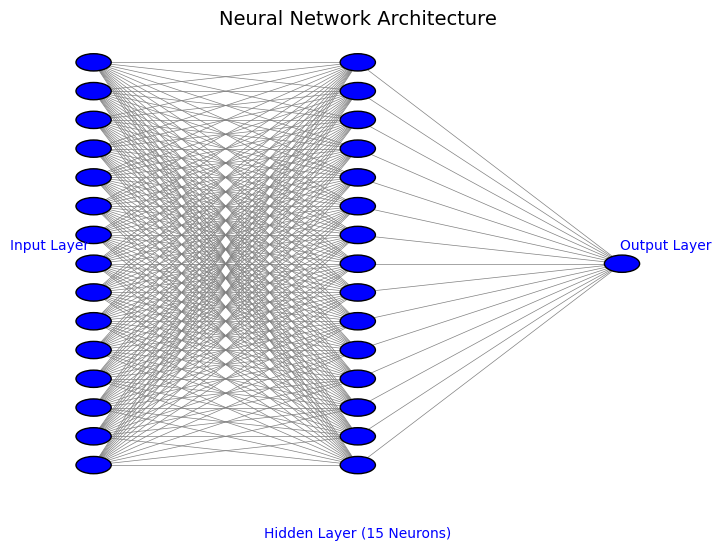

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(SimpleMLP, self).__init__()
        # Create hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_layers[0])
        # Output layer
        self.fc2 = nn.Linear(hidden_layers[0], 1)
        self.activation = nn.ReLU()
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.output_activation(self.fc2(x))
        return x

# Step 6: Visualize network architecture
def visualize_network(input_dim, hidden_layers):
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.set_title("Neural Network Architecture", fontsize=14)
    ax.axis('off')
    
    # Define the layer structure
    layers = [(input_dim, 0)] + [(hidden_layers[0], 1), (1, 2)]
    
    max_nodes = max(input_dim, *hidden_layers, 1)
    spacing_y = 10 / max_nodes
    spacing_x = 3

    # Plot each layer
    for i, (n_nodes, x_pos) in enumerate(layers):
        for j in range(n_nodes):
            y_pos = j * spacing_y - (n_nodes / 2) * spacing_y
            circle = plt.Circle((x_pos * spacing_x, y_pos), radius=0.2, color='b', ec='k', zorder=2)
            ax.add_patch(circle)

            # Draw connections to the next layer
            if i < len(layers) - 1:
                next_n_nodes = layers[i + 1][0]
                next_x_pos = layers[i + 1][1] * spacing_x
                for k in range(next_n_nodes):
                    next_y_pos = k * spacing_y - (next_n_nodes / 2) * spacing_y
                    plt.plot([x_pos * spacing_x, next_x_pos], [y_pos, next_y_pos], color='gray', linewidth=0.5, zorder=1)

    plt.text(0 * spacing_x - 0.5, 0, "Input Layer", ha='center', fontsize=10, color='blue')
    plt.text(1 * spacing_x, -max_nodes * spacing_y / 1.5, "Hidden Layer (5 Neurons)", ha='center', fontsize=10, color='blue')
    plt.text(2 * spacing_x + 0.5, 0, "Output Layer", ha='center', fontsize=10, color='blue')
    plt.show()

# Step 7: Display the architecture of the network
input_dim = 5  # Adjust this as needed for your dataset's feature count
hidden_layers = [5]
visualize_network(input_dim, hidden_layers)

In [7]:
# Step 8: Function to train the model
def train_model(model, criterion, optimizer, X_train, y_train, n_epochs=100):
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)
        train_loss.backward()
        optimizer.step()

# Step 9: Function to evaluate the model and return metrics and confusion matrix
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).cpu().numpy()
    y_pred_class = (y_pred > 0.5).astype(int)
    y_test_np = y_test.cpu().numpy()
    
    accuracy = accuracy_score(y_test_np, y_pred_class)
    precision = precision_score(y_test_np, y_pred_class, zero_division=0)
    recall = recall_score(y_test_np, y_pred_class, zero_division=0)
    f1 = f1_score(y_test_np, y_pred_class, zero_division=0)
    conf_matrix = confusion_matrix(y_test_np, y_pred_class)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'conf_matrix': conf_matrix
    }

In [8]:
# Step 10: Function to plot confusion matrix using matplotlib
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Cancer', 'Cancer'])
    plt.yticks(tick_marks, ['No Cancer', 'Cancer'])

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

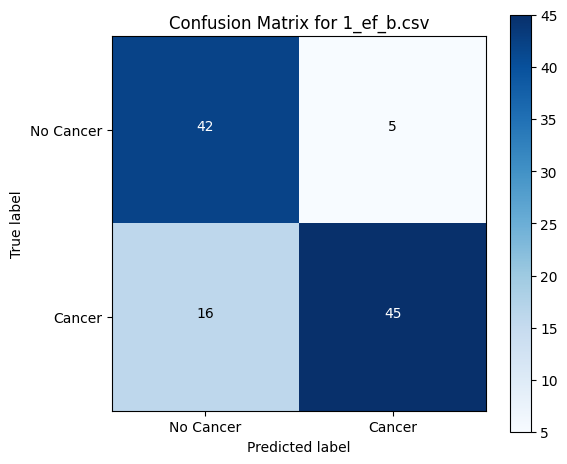

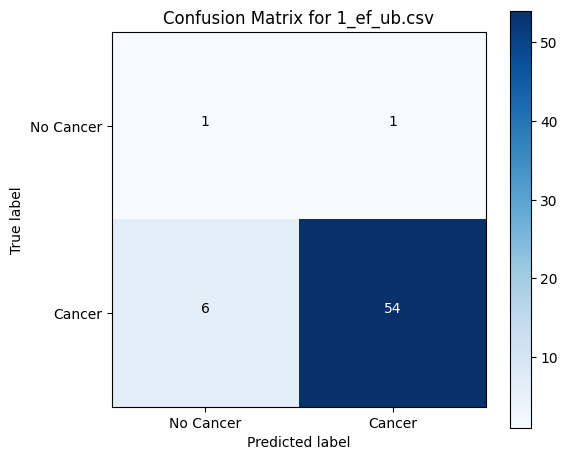

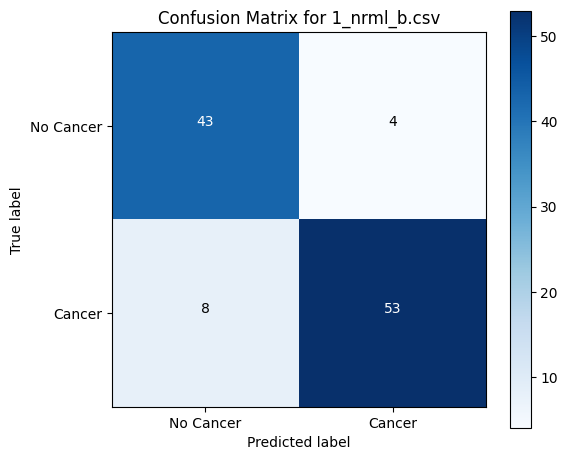

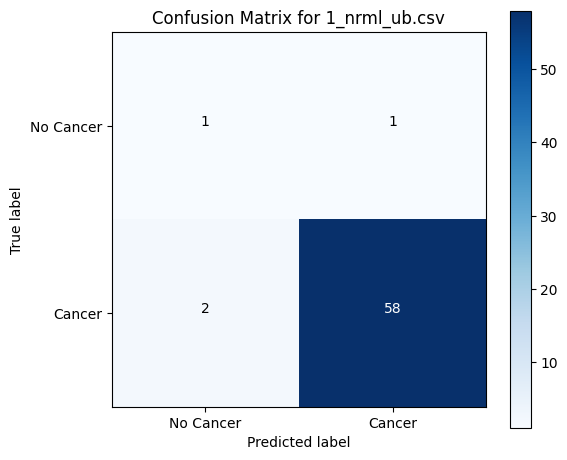

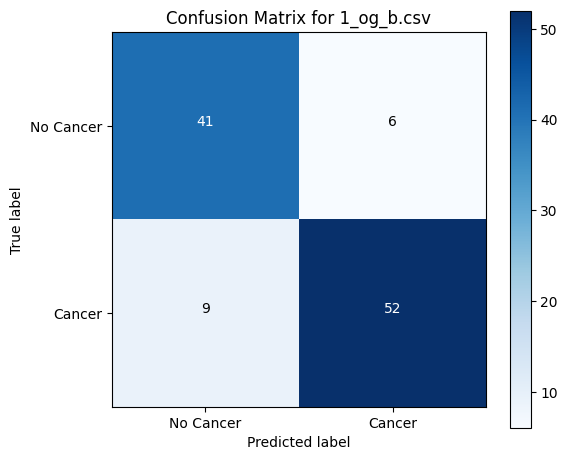

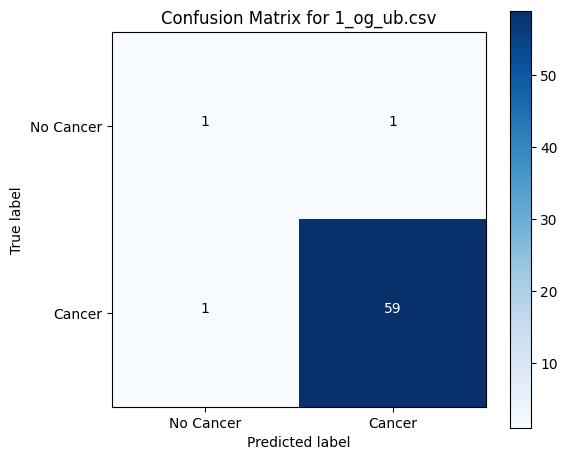

         Dataset  Accuracy  Precision    Recall  F1 Score
0     1_ef_b.csv  0.805556   0.900000  0.737705  0.810811
1    1_ef_ub.csv  0.887097   0.981818  0.900000  0.939130
2   1_nrml_b.csv  0.888889   0.929825  0.868852  0.898305
3  1_nrml_ub.csv  0.951613   0.983051  0.966667  0.974790
4     1_og_b.csv  0.861111   0.896552  0.852459  0.873950
5    1_og_ub.csv  0.967742   0.983333  0.983333  0.983333


In [9]:
# Step 11: Evaluate all datasets
results = []
for dataset_path in dataset_paths:
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data(dataset_path)
    input_dim = X_train.shape[1]
    
    # Initialize model, loss, and optimizer
    model = SimpleMLP(input_dim, hidden_layers=[15]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_model(model, criterion, optimizer, X_train, y_train, n_epochs=100)
    
    # Evaluate model
    eval_metrics = evaluate_model(model, X_test, y_test)
    
    # Store results
    results.append({
        'dataset': dataset_path,
        'metrics': eval_metrics
    })

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    dataset_name = os.path.basename(dataset_path)
    plot_confusion_matrix(eval_metrics['conf_matrix'], title=f'Confusion Matrix for {dataset_name}')
    plt.show()

# Step 12: Collect results in a DataFrame for easy comparison
metrics_summary = pd.DataFrame([
    {
        'Dataset': os.path.basename(result['dataset']),  # Use only the file name
        'Accuracy': result['metrics']['accuracy'],
        'Precision': result['metrics']['precision'],
        'Recall': result['metrics']['recall'],
        'F1 Score': result['metrics']['f1_score']
    }
    for result in results
])

# Step 13: Display the metrics summary
print(metrics_summary)


Training model with hidden layers: [15]
Hidden Layers [15]: F1-Score = 0.888888888888889

Training model with hidden layers: [15, 15]
Hidden Layers [15, 15]: F1-Score = 0.912280701754386

Training model with hidden layers: [15, 15, 15]
Hidden Layers [15, 15, 15]: F1-Score = 0.9482758620689655

Training model with hidden layers: [15, 15, 15, 15]
Hidden Layers [15, 15, 15, 15]: F1-Score = 0.9482758620689655

Training model with hidden layers: [15, 15, 15, 15, 15]
Hidden Layers [15, 15, 15, 15, 15]: F1-Score = 0.9482758620689655

Training model with hidden layers: [15, 15, 15, 15, 15, 15]
Hidden Layers [15, 15, 15, 15, 15, 15]: F1-Score = 0.9298245614035088

Training model with hidden layers: [15, 15, 15, 15, 15, 15, 15]
Hidden Layers [15, 15, 15, 15, 15, 15, 15]: F1-Score = 0.9482758620689655

Training model with hidden layers: [15, 15, 15, 15, 15, 15, 15, 15]
Hidden Layers [15, 15, 15, 15, 15, 15, 15, 15]: F1-Score = 0.9482758620689655

Training model with hidden layers: [15, 15, 15, 1

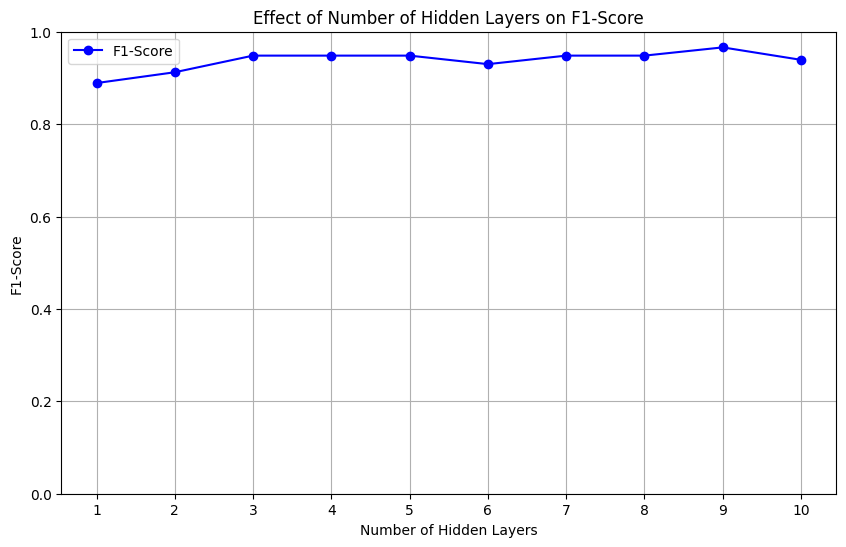

In [ ]:
# Define a configurable MLP architecture with variable hidden layers
class ConfigurableMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(ConfigurableMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        # Add hidden layers
        for neurons in hidden_layers:
            layers.append(nn.Linear(prev_dim, neurons))
            layers.append(nn.ReLU())  # Activation function
            prev_dim = neurons
        # Add output layer
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())  # Sigmoid for binary classification
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Load the dataset
dataset_path = r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_ef_b.csv'
X_train, X_test, y_train, y_test = load_and_preprocess_data(dataset_path)

# Number of features (input dimension)
input_dim = X_train.shape[1]

# Initialize configurations
hidden_layer_configurations = [
    [15],        # 1 hidden layer
    [15, 15],    # 2 hidden layers
    [15, 15, 15],  # 3 hidden layers
    [15, 15, 15, 15],  # 4 hidden layers
    [15, 15, 15, 15, 15],  # 5 hidden layers
    [15, 15, 15, 15, 15, 15], # 6 hidden
    [15, 15, 15, 15, 15, 15, 15], #7
    [15, 15, 15, 15, 15, 15, 15, 15], #8
    [15, 15, 15, 15, 15, 15, 15, 15, 15], #9
    [15, 15, 15, 15, 15, 15, 15, 15, 15, 15] #10
    

]

# Store results for each configuration
f1_scores = []

# Train and evaluate models with different hidden layer configurations
for hidden_layers in hidden_layer_configurations:
    print(f"\nTraining model with hidden layers: {hidden_layers}")
    # Initialize model, criterion, and optimizer
    model = ConfigurableMLP(input_dim, hidden_layers).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, criterion, optimizer, X_train, y_train, n_epochs=200)

    # Evaluate the model
    eval_metrics = evaluate_model(model, X_test, y_test)
    f1_scores.append(eval_metrics['f1_score'])

    # Print evaluation metrics
    print(f"Hidden Layers {hidden_layers}: F1-Score = {eval_metrics['f1_score']}")

# Plot the F1-score comparison as a line graph
hidden_layer_labels = [len(layers) for layers in hidden_layer_configurations]  # Number of hidden layers
plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_labels, f1_scores, marker='o', linestyle='-', color='blue', label='F1-Score')
plt.title('Effect of Number of Hidden Layers on F1-Score')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('F1-Score')
plt.ylim(0, 1)  # F1-score range is [0, 1]
plt.xticks(hidden_layer_labels)  # Ensure all hidden layer counts are shown on the x-axis
plt.grid(axis='both')
plt.legend()
plt.show()